In [15]:
import os, sys
from os.path import expanduser
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython3/lib/python' % user_home
model_home = '%s/src/model' % user_home
dentate_home = '%s/dentate' % model_home
datasets_home = '/media/igr/d865f900-7fcd-45c7-a7a7-bd2a7391bc40/Data/DG/'
results_prefix = os.getenv('DG_RESULTS_DIR', '%s/results' % datasets_home)
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import neuroh5
from neuroh5.io import read_population_ranges, read_population_names, read_cell_attributes
import dentate
from dentate import utils, plot, stimulus, spikedata
from dentate.env import Env
from dentate.utils import Struct, zip_longest

In [50]:
def pf_dist(reference, result):
    dists = []
    for i in range(result.shape[0]):
        dists_i = []
        for j in range(reference.shape[0]):
            dist = np.linalg.norm(result[i, :] - reference[j, :])
            dists_i.append(dist)
        dists.append(np.min(np.asarray(dists_i)))
    return np.mean(dists)
        
    

In [25]:
bin_size = 5.
config_path = '%s/config/Full_Scale_Basis.yaml' % dentate_home
template_path = '%s/templates' % dentate_home

rel_spike_events_path = 'Full_Scale_GC_Exc_Sat_DD_SLN_Diag_10618023.bw/dentatenet_Full_Scale_GC_Exc_Sat_DD_SLN_results_compressed.h5'
spike_events_path = '%s/%s' % (results_prefix, rel_spike_events_path)
spike_events_namespace_id = 'Spike Events'
                          
rel_input_features_path = 'Full_Scale_Control/DG_input_features_20191119_compressed.h5'
input_features_path = '%s/%s' % (datasets_home, rel_input_features_path)
input_features_namespace_id = 'Place Selectivity A'

trajectory_path = '%s/Full_Scale_Control/DG_remap_spike_trains_20191113_compressed.h5' % datasets_home

arena_id = 'A'
trajectory_id = 'Diag'



In [11]:
baks_config = Struct(**{'BAKS Alpha': 4.77,'BAKS Beta': None})
pf_config = Struct(**{'Minimum Width': 15., 'Minimum Rate': 1.0})

env = None
if config_path is not None:
    env = Env(config_file=config_path, template_paths=template_path)
    if env.analysis_config is not None:
        baks_config.update(env.analysis_config['Firing Rate Inference'])
        pf_config.update(env.analysis_config['Place Fields'])



In [12]:
trajectory = stimulus.read_trajectory(trajectory_path, arena_id, trajectory_id)

In [59]:
it = read_cell_attributes(input_features_path, 'GC', namespace=input_features_namespace_id)
GC_input_features = dict(it)
it = read_cell_attributes(input_features_path, 'LPP', namespace=input_features_namespace_id)
LPP_input_features = dict(it)

In [9]:
populations = ['GC', 'LPP']
PF_arena_dicts = defaultdict(lambda: defaultdict(lambda: None))
this_spike_namespace = '%s %s %s' % (spike_events_namespace_id, arena_id, trajectory_id)
this_spike_namespace = spike_namespace_id
print('reading %s' % spike_input_path)
spkdata = spikedata.read_spike_events(spike_input_path, populations, this_spike_namespace,
                                          spike_train_attr_name='t', time_range=[500., 9500.])

spkpoplst = spkdata['spkpoplst']
spkindlst = spkdata['spkindlst']
spktlst = spkdata['spktlst']
num_cell_spks = spkdata['num_cell_spks']
pop_active_cells = spkdata['pop_active_cells']
tmin = spkdata['tmin']
tmax = spkdata['tmax']

time_range = [tmin, tmax]
time_bins  = np.arange(time_range[0], time_range[1], bin_size)

for i, subset in enumerate(spkpoplst):

    spkts         = spktlst[i]
    spkinds       = spkindlst[i]
    spkdict       = spikedata.make_spike_dict(spkinds, spkts)

    rate_bin_dict = spikedata.spike_density_estimate(subset, spkdict, time_bins, arena_id=arena_id,
                                                             trajectory_id=trajectory_id, progress=True, **baks_config())
    PF_dict = spikedata.place_fields(subset,  65., rate_bin_dict, trajectory, arena_id=arena_id,
                                         trajectory_id=trajectory_id, progress=True, **pf_config())
        
    PF_arena_dicts[arena_id][subset] = PF_dict

reading /media/igr/d865f900-7fcd-45c7-a7a7-bd2a7391bc40/Data/DG//results/Full_Scale_GC_Exc_Sat_DD_SLN_Diag_10618023.bw/dentatenet_Full_Scale_GC_Exc_Sat_DD_SLN_results_compressed.h5


100%|██████████| 12541/12541 [01:23<00:00, 150.52it/s]


In [46]:
LPP_input_features_keys = set([ k for k in LPP_input_features.keys() if len(LPP_input_features[k]['X Offset']) > 0])
print(len(LPP_input_features_keys))
LPP_pf_keys = set([ k for k in PF_arena_dicts[arena_id]['LPP'].keys() if len(PF_arena_dicts[arena_id]['LPP'][k]['pf_x_locs']) > 0])
print(len(LPP_pf_keys))

18189
10874


In [47]:
LPP_pf_intersection = LPP_input_features_keys.intersection(LPP_pf_keys)
print(len(LPP_pf_intersection))

10874


In [57]:
LPP_pf_dists = []
LPP_pf_dict = PF_arena_dicts[arena_id]['LPP']
for gid in LPP_pf_intersection:
    reference_x = LPP_input_features[gid]['X Offset']
    reference_y = LPP_input_features[gid]['Y Offset']
    result_x = LPP_pf_dict[gid]['pf_x_locs']
    result_y = LPP_pf_dict[gid]['pf_y_locs']
    reference_locs = np.column_stack((reference_x, reference_y))
    result_locs = np.column_stack((result_x, result_y))
    LPP_pf_dists.append(pf_dist(reference_locs, result_locs))
LPP_pf_dists_array = np.asarray(sorted(LPP_pf_dists))


33.7005168243749


0.36732218159072977 370.01670394530595 33.7005168243749


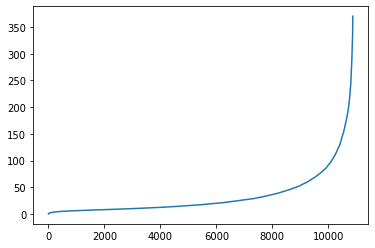

In [58]:
print(np.min(LPP_pf_dists_array), np.max(LPP_pf_dists_array), np.mean(LPP_pf_dists_array))
plt.plot(LPP_pf_dists_array)

In [61]:
GC_input_features_keys = set([ k for k in GC_input_features.keys() if len(GC_input_features[k]['X Offset']) > 0])
print(len(GC_input_features_keys))
GC_pf_keys = set([ k for k in PF_arena_dicts[arena_id]['GC'].keys() if len(PF_arena_dicts[arena_id]['GC'][k]['pf_x_locs']) > 0])
print(len(GC_pf_keys))

196901
5501


In [62]:
GC_pf_intersection = GC_input_features_keys.intersection(GC_pf_keys)
print(len(GC_pf_intersection))

1172


In [63]:
GC_pf_dists = []
GC_pf_dict = PF_arena_dicts[arena_id]['GC']
for gid in GC_pf_intersection:
    reference_x = GC_input_features[gid]['X Offset']
    reference_y = GC_input_features[gid]['Y Offset']
    result_x = GC_pf_dict[gid]['pf_x_locs']
    result_y = GC_pf_dict[gid]['pf_y_locs']
    reference_locs = np.column_stack((reference_x, reference_y))
    result_locs = np.column_stack((result_x, result_y))
    GC_pf_dists.append(pf_dist(reference_locs, result_locs))
GC_pf_dists_array = np.asarray(sorted(GC_pf_dists))


1.954162025046514 477.9722084831298 100.44415783543657


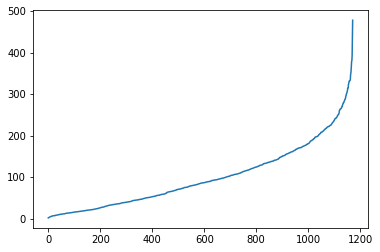

In [64]:
print(np.min(GC_pf_dists_array), np.max(GC_pf_dists_array), np.mean(GC_pf_dists_array))
plt.plot(GC_pf_dists_array)